In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [158]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=None):
  print("The training set:")
  y_train_pred = model.predict(X_train)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))
  '''
  if hasattr(model, "validation_scores_"):
    epochs = np.arange(1, len(model.loss_curve_)+1)

    fig, ax1 = plt.subplots(figsize=(10,6))

    # plot training loss on left y-axis
    ax1.plot(epochs, model.loss_curve_, color="tab:red", label="Training Loss", linewidth=2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # create a second axis for validation accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, model.validation_scores_, color="tab:blue", label="Validation Accuracy", linewidth=2)
    ax2.set_ylabel("Validation Accuracy", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylim([0.5,1])

    plt.title("MLP Training Loss and Validation Accuracy")
    fig.tight_layout()
    plt.show()
  '''

  # ---- ROC Curve ----
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [95]:
# load data
IIn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful.csv')
II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[68].csv')
Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/supernova_parameters_successful[75].csv')

Attempt 1: Original dataset

In [162]:
data = pd.concat([IIn, II, Ia], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

skip = {'supernova', 'type', 'band', 'n_obs', 'flux_scale', 'redshift'}
feature_cols = [c for c in data.columns if c not in skip]

# features
X = data[feature_cols]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X = X.clip(lower=lower, upper=upper, axis=1)

# labels
y = data['type']
y = y.map({'IIn': 0, 'II': 1, 'Ia': 2})

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=y
)

class_weights_dict = dict(enumerate(class_weights))

# get mapping for checking
print("Unique mapped labels:", y.unique())

# count examples in classes
pd.Series(y).value_counts()

Unique mapped labels: [2 1 0]


,count
type,
2,10708
1,1183
0,276


In [163]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

scaler = RobustScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [231]:
model1 = MLPClassifier(
    hidden_layer_sizes=(128,64,32),
    activation='relu',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

model1.fit(X_train1,y_train1)

Iteration 1, loss = 0.44253405
Validation score: 0.861396
Iteration 2, loss = 0.35625642
Validation score: 0.861396
Iteration 3, loss = 0.34846849
Validation score: 0.865503
Iteration 4, loss = 0.34368807
Validation score: 0.867556
Iteration 5, loss = 0.34296244
Validation score: 0.865503
Iteration 6, loss = 0.33773634
Validation score: 0.867556
Iteration 7, loss = 0.33654910
Validation score: 0.865503
Iteration 8, loss = 0.33291412
Validation score: 0.867556
Iteration 9, loss = 0.33112457
Validation score: 0.868583
Iteration 10, loss = 0.32913468
Validation score: 0.867556
Iteration 11, loss = 0.32813041
Validation score: 0.862423
Iteration 12, loss = 0.32546786
Validation score: 0.865503
Iteration 13, loss = 0.32300977
Validation score: 0.865503
Iteration 14, loss = 0.32252848
Validation score: 0.867556
Iteration 15, loss = 0.32100770
Validation score: 0.867556
Iteration 16, loss = 0.31998748
Validation score: 0.867556
Iteration 17, loss = 0.31568852
Validation score: 0.857290
Iterat

MLPClassifier(alpha=0.001, batch_size=32, early_stopping=True,
              hidden_layer_sizes=(128, 64, 32), learning_rate='adaptive',
              max_iter=500, verbose=True)

The training set:

 Validation accuracy:  0.8902702147333813

 Classification report:
                precision    recall  f1-score   support

           0       1.00      0.03      0.06       221
           1       0.61      0.19      0.29       946
           2       0.90      0.99      0.94      8566

    accuracy                           0.89      9733
   macro avg       0.84      0.40      0.43      9733
weighted avg       0.87      0.89      0.86      9733


 Confusion matrix:
 [[   7   29  185]
 [   0  177  769]
 [   0   85 8481]]

The test set:

 Validation accuracy:  0.8853738701725554

 Classification report:
                precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.56      0.14      0.22       237
           2       0.89      0.99      0.94      2142

    accuracy                           0.89      2434
   macro avg       0.48      0.38      0.39      2434
weighted avg       0.84      0.89      0.85 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-1962543749.py:51: MatplotlibDe

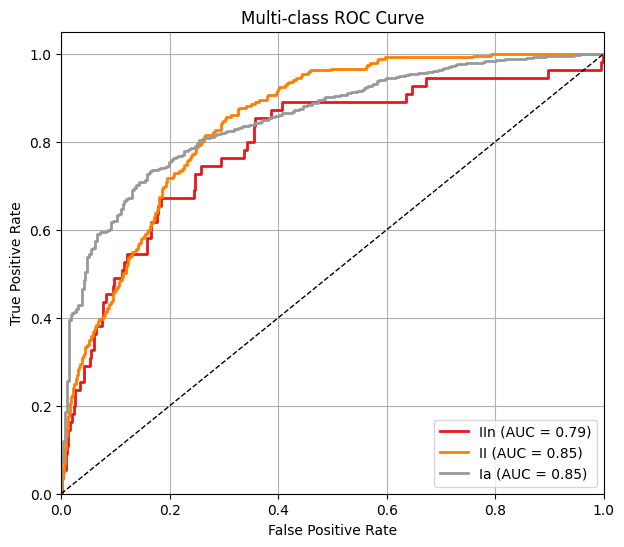

In [232]:
evaluate_model(model1, X_train1, y_train1, X_test1, y_test1, ['IIn','II','Ia'])

Attempt 2: Downsample

In [171]:
Ia_down = Ia.sample(2000)

data_down = pd.concat([IIn, II, Ia_down], ignore_index=True)
data_down = data_down.sample(frac=1, random_state=42).reset_index(drop=True)

# features
X_down = data_down[feature_cols]

Q1 = X_down.quantile(0.25)
Q3 = X_down.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_down = X_down.clip(lower=lower, upper=upper, axis=1)

# labels
y_down = data_down['type']
y_down = y_down.map({'IIn': 0, 'II': 1, 'Ia': 2})

# get mapping for checking
print("Unique mapped labels:", y_down.unique())

# count examples in classes
pd.Series(y_down).value_counts()

Unique mapped labels: [1 2 0]


,count
type,
2,2000
1,1183
0,276


In [172]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_down, y_down,
    test_size=0.2,
    random_state=42,
    stratify=y_down,
    shuffle=True
)

scaler = RobustScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [194]:
model2 = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation='relu',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

model2.fit(X_train2,y_train2)

Iteration 1, loss = 0.87737136
Validation score: 0.638989
Iteration 2, loss = 0.76310866
Validation score: 0.660650
Iteration 3, loss = 0.73819310
Validation score: 0.678700
Iteration 4, loss = 0.72637376
Validation score: 0.675090
Iteration 5, loss = 0.71657370
Validation score: 0.667870
Iteration 6, loss = 0.70772268
Validation score: 0.682310
Iteration 7, loss = 0.70603588
Validation score: 0.678700
Iteration 8, loss = 0.69814325
Validation score: 0.671480
Iteration 9, loss = 0.69680205
Validation score: 0.675090
Iteration 10, loss = 0.69340974
Validation score: 0.685921
Iteration 11, loss = 0.68852181
Validation score: 0.667870
Iteration 12, loss = 0.68234363
Validation score: 0.682310
Iteration 13, loss = 0.68134014
Validation score: 0.685921
Iteration 14, loss = 0.67946834
Validation score: 0.682310
Iteration 15, loss = 0.67499519
Validation score: 0.689531
Iteration 16, loss = 0.67267915
Validation score: 0.693141
Iteration 17, loss = 0.66784783
Validation score: 0.689531
Iterat

MLPClassifier(alpha=0.001, batch_size=32, early_stopping=True,
              hidden_layer_sizes=(128, 64), learning_rate='adaptive',
              max_iter=500, verbose=True)

The training set:

 Validation accuracy:  0.7289483194795807

 Classification report:
                precision    recall  f1-score   support

           0       0.92      0.05      0.09       221
           1       0.66      0.62      0.64       946
           2       0.76      0.89      0.82      1600

    accuracy                           0.73      2767
   macro avg       0.78      0.52      0.52      2767
weighted avg       0.74      0.73      0.70      2767


 Confusion matrix:
 [[  11  127   83]
 [   0  584  362]
 [   1  177 1422]]

The test set:

 Validation accuracy:  0.6965317919075145

 Classification report:
                precision    recall  f1-score   support

           0       1.00      0.04      0.07        55
           1       0.60      0.59      0.59       237
           2       0.74      0.85      0.79       400

    accuracy                           0.70       692
   macro avg       0.78      0.49      0.49       692
weighted avg       0.72      0.70      0.67 

/tmp/ipython-input-1962543749.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


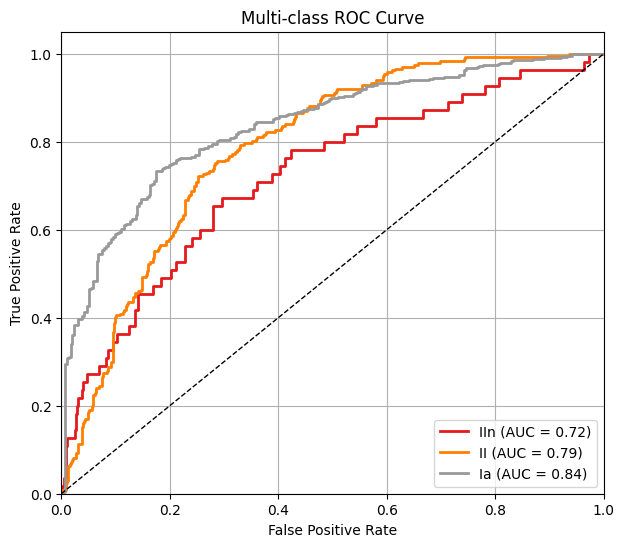

In [195]:
evaluate_model(model2, X_train2, y_train2, X_test2, y_test2, ['IIn','II','Ia'])

Attempt 3: Use TensorFlow library instead of scikit-learn

In [134]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [196]:
def evaluate_model_tf(model, history, X_train, y_train, X_test, y_test, class_names=None):
    print("=== Training Set ===")
    y_train_pred = np.argmax(model.predict(X_train), axis=1)

    print("\nAccuracy:", accuracy_score(y_train, y_train_pred))
    print("\nClassification report:\n", classification_report(y_train, y_train_pred))
    print("\nConfusion matrix:\n", confusion_matrix(y_train, y_train_pred))

    print("\n=== Test Set ===")
    y_test_pred = np.argmax(model.predict(X_test), axis=1)

    print("\nAccuracy:", accuracy_score(y_test, y_test_pred))
    print("\nClassification report:\n", classification_report(y_test, y_test_pred))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, y_test_pred))
    '''
    # ---- Plot training curves ----
    epochs = np.arange(1, len(history.history['loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(8,5))

    # Loss on left axis
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(epochs, history.history["loss"], label="Train Loss", color="tab:red")
    if "val_loss" in history.history:
        ax1.plot(epochs, history.history["val_loss"], label="Val Loss", linestyle="--", color="tab:red")
    ax1.tick_params(axis='y', labelcolor="tab:red")

    # Accuracy on right axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(epochs, history.history["accuracy"], label="Train Acc", color="tab:blue")
    if "val_accuracy" in history.history:
        ax2.plot(epochs, history.history["val_accuracy"], label="Val Acc", linestyle="--", color="tab:blue")
    ax2.tick_params(axis='y', labelcolor="tab:blue")

    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper right")

    plt.title("Training Loss and Accuracy")
    plt.grid(True)
    plt.show()
    '''
    # ---- ROC Curve ----
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_score = model.predict(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(7,6))
    colors = plt.cm.get_cmap('Set1', n_classes)
    for i in range(n_classes):
        label = f"Class {i}" if class_names is None else class_names[i]
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [228]:
n_features = 6
n_classes = 3

model3 = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [229]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history3 = model3.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5510 - loss: 1.0691 - val_accuracy: 0.6208 - val_loss: 0.9156
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6350 - loss: 0.9478 - val_accuracy: 0.6220 - val_loss: 0.8542
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6789 - loss: 0.9163 - val_accuracy: 0.7149 - val_loss: 0.8513
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7131 - loss: 0.9062 - val_accuracy: 0.7046 - val_loss: 0.8368
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7033 - loss: 0.9409 - val_accuracy: 0.7132 - val_loss: 0.8117
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7179 - loss: 0.8855 - val_accuracy: 0.6816 - val_loss: 0.8793
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7097 - loss: 0.8770 - val_accuracy: 0.7017 - val_loss: 0.8278
Epoch 8/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7161 - loss: 0.8766 - val_accuracy: 0.

=== Training Set ===
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Accuracy: 0.7507448885235796

Classification report:
               precision    recall  f1-score   support

           0       0.10      0.56      0.17       221
           1       0.28      0.42      0.33       946
           2       0.96      0.79      0.87      8566

    accuracy                           0.75      9733
   macro avg       0.45      0.59      0.46      9733
weighted avg       0.87      0.75      0.80      9733


Confusion matrix:
 [[ 124   51   46]
 [ 279  396  271]
 [ 807  972 6787]]

=== Test Set ===
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Accuracy: 0.7370583401807724

Classification report:
               precision    recall  f1-score   support

           0       0.08      0.49      0.14        55
           1       0.27      0.39      0.32       237
           2       0.95      0.78      0.86      2142

    accuracy                           0.74      2434
   macro avg       0.43      0.55      0.44

/tmp/ipython-input-4282263922.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


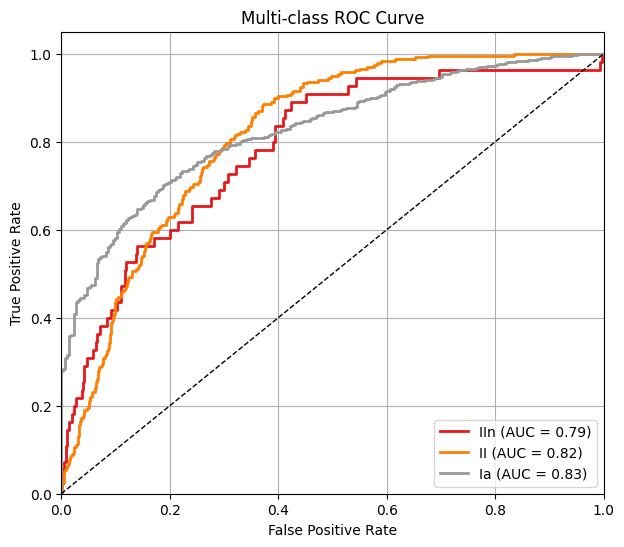

In [230]:
evaluate_model_tf(model3, history3, X_train1, y_train1, X_test1, y_test1, ['IIn','II','Ia'])

Attempt 4: Use TensorFlow and downsample

In [247]:
model4 = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model4.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history4 = model4.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_down_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5489 - loss: 1.0408 - val_accuracy: 0.4653 - val_loss: 0.9896
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5141 - loss: 0.9601 - val_accuracy: 0.5578 - val_loss: 0.9494
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5583 - loss: 0.9334 - val_accuracy: 0.5867 - val_loss: 0.9161
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6160 - loss: 0.9310 - val_accuracy: 0.5795 - val_loss: 0.9374
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5844 - loss: 0.9338 - val_accuracy: 0.5650 - val_loss: 0.9454
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6210 - loss: 0.8695 - val_accuracy: 0.5882 - val_loss: 0.9128
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6029 - loss: 0.8789 - val_accuracy: 0.6012 - val_loss: 0.9048
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6377 - loss: 0.8804 - val_accuracy: 0.5780 - val_los

=== Training Set ===
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Accuracy: 0.6404047705095771

Classification report:
               precision    recall  f1-score   support

           0       0.23      0.54      0.32       221
           1       0.59      0.49      0.54       946
           2       0.81      0.74      0.78      1600

    accuracy                           0.64      2767
   macro avg       0.54      0.59      0.54      2767
weighted avg       0.69      0.64      0.66      2767


Confusion matrix:
 [[ 119   51   51]
 [ 254  461  231]
 [ 143  265 1192]]

=== Test Set ===
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Accuracy: 0.619942196531792

Classification report:
               precision    recall  f1-score   support

           0       0.20      0.47      0.28        55
           1       0.56      0.51      0.53       237
           2       0.82      0.71      0.76       400

    accuracy                           0.62       692
   macro avg       0.53      0.56      0.52  

/tmp/ipython-input-4282263922.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


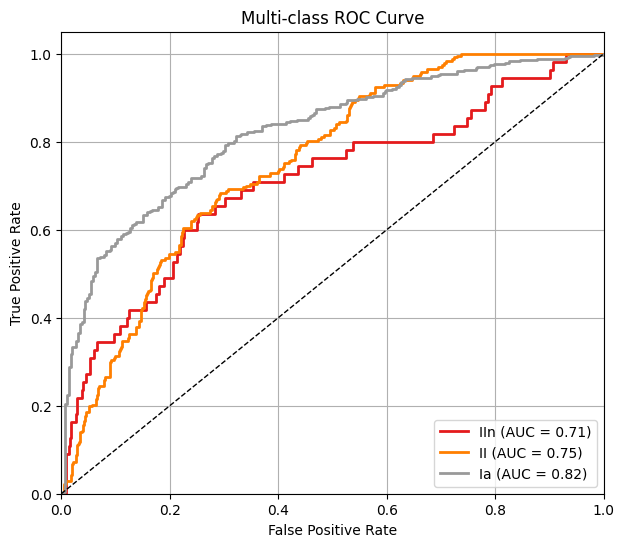

In [249]:
evaluate_model_tf(model4, history4, X_train2, y_train2, X_test2, y_test2, ['IIn','II','Ia'])